<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Executive-Summary" data-toc-modified-id="Executive-Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Executive Summary</a></span><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dependencies</a></span></li></ul></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Motivation" data-toc-modified-id="Motivation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Motivation</a></span></li><li><span><a href="#Experimental-Design" data-toc-modified-id="Experimental-Design-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Experimental Design</a></span><ul class="toc-item"><li><span><a href="#Data-Collection" data-toc-modified-id="Data-Collection-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data Collection</a></span></li><li><span><a href="#Streaming-Algorithm-Design" data-toc-modified-id="Streaming-Algorithm-Design-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Streaming Algorithm Design</a></span></li></ul></li><li><span><a href="#Optimisation" data-toc-modified-id="Optimisation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Optimisation</a></span><ul class="toc-item"><li><span><a href="#Event-Detection" data-toc-modified-id="Event-Detection-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Event Detection</a></span><ul class="toc-item"><li><span><a href="#Test-Statistic" data-toc-modified-id="Test-Statistic-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Test Statistic</a></span></li><li><span><a href="#Evaluation-Metric-(Contrast)" data-toc-modified-id="Evaluation-Metric-(Contrast)-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Evaluation Metric (Contrast)</a></span></li><li><span><a href="#Threshold-Optimisation" data-toc-modified-id="Threshold-Optimisation-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Threshold Optimisation</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Classifiers" data-toc-modified-id="Classifiers-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Classifiers</a></span></li><li><span><a href="#Accuracy-Metric" data-toc-modified-id="Accuracy-Metric-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Accuracy Metric</a></span></li><li><span><a href="#Classifier-Optimisation" data-toc-modified-id="Classifier-Optimisation-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Classifier Optimisation</a></span></li></ul></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Space-Invaders!" data-toc-modified-id="Space-Invaders!-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Space Invaders!</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Appendix</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Making Space Invaders Fun and Accessible with Brain-Computer Interfacing

## Executive Summary

### Dependencies

In [22]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import time
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
from copy import deepcopy
from catch22 import catch22_all
import catch22
from sklearn.neighbors import KNeighborsClassifier
from numba import njit
from weighted_levenshtein import lev
import struct


# Disables plots. Comment out this line to show plots generated from code.
%matplotlib agg

# Set seed for reproducibility
np.random.seed(420)
# Path to outputs folder
OUT_PATH = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Report/report_outputs/"
# Path to data
IN_PATH = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Datasets/data/"
# Path to other file dependencies
DEP_PATH = "/Users/billydodds/Documents/Uni/DATA3888/Aqua10/Report/requirements/other_files/"


## Introduction

## Motivation

## Experimental Design

### Data Collection
We have prepared 8 wave files (.wav) to the following specifications:
- 50 seconds in length
- First 5 seconds is a calibration period - no movements performed
- A sequence of left and right movements are performed for the remaining 45 seconds
- Each file is accompanied with a labels textfile (.txt) containing the timestamps and labels of every event in the wavefile. '1' corresponds to a left eye movement, and '2' corresponds to a right eye movement.
- Each .wav file has a range of [0, 1024], but are centred to [-512, 512] within the `load_data` function defined below.

Two of the eight files were randomly selected as the test set, and the rest were assigned to the training set. The files were re-numbered such that 7 and 8 correspond to those chosen for the test set.

In [23]:
def load_data(path, fnames, scale_factor = 1, shift_factor = -512):
    waves = {}
    labels = {}
    for file in fnames:
        # Load in wave file
        samprate, wav_array = wavfile.read(path+file+".wav")
        wav_array = wav_array*scale_factor
        wav_array += shift_factor
        waves[file] = wav_array
        # Load in label file
        labels_dat = pd.read_csv(path+file+".txt", sep=",\t", skiprows=1)
        labels_dat.columns = ["label", "time"]
        labels_dat.label = ["L" if label == 1 else "R" for label in labels_dat.label]
        labels[file] = labels_dat
    print(f"Successfully loaded {len(waves)} wavefiles:")
    print("\n".join(sorted(waves.keys())))
    return waves, labels

fnames = ["data1", "data2", "data3", "data4", "data5", "data6", "data7", "data8"]

# Randomly select two files for the test set, remainder as training
test_files = np.random.choice(fnames, 2, replace=False)
training_files = list(set(fnames) - set(test_files))

# Training Data
waves, labels = load_data(
    IN_PATH, training_files, scale_factor = 1, shift_factor = -512)

# Test Data
test_waves, test_labels = load_data(
    IN_PATH, test_files, scale_factor = 1, shift_factor = -512)

# Define Sample Rate: 10,000 Hz
samprate = 10_000


Successfully loaded 6 wavefiles:
data1
data2
data3
data4
data6
data8
Successfully loaded 2 wavefiles:
data5
data7


<ipython-input-23-a8397ba8da66>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file+".txt", sep=",\t", skiprows=1)


Next, we convert the singular timestamps in the labels dataframe to the time interval of the entire event. There was a minor data quality issue with some of the timestamps which caused some files to have slightly shifted timestamps. To fix this, we went through and manually defined the interval for each file (the time to add before and after the timestamp to get the desired interval). We did this once to encompass the entire wave signal, and another time to only cover the first hump of the signal.


In [17]:
# First hump
time_buffers_hump = {
    "data1":(-0.3, 0.55),
    "data2":(-0.3, 0.55),
    "data3":(-0.3, 0.55),
    "data4":(-0.5, 0.75),
    "data5":(-0.5, 0.75),
    "data6":(-0.5, 0.75),
    "data7":(-0.5, 0.75),
    "data8":(-0.5, 0.75)
}

# Whole wave
time_buffers_whole = {
    "data1":(-0.2, 1.15),
    "data2":(-0.2, 1.15),
    "data3":(-0.2, 1.15),
    "data4":(-0.4, 1.35),
    "data5":(-0.4, 1.35),
    "data6":(-0.4, 1.35),
    "data7":(-0.4, 1.35),
    "data8":(-0.4, 1.35),
}


In [21]:
def plot_labelled_wave(wav_array, samprate, labels_dat, ax, i, title="", calibration_seconds = 5, 
                       before_buffer = 1, after_buffer = 1, shade_alpha=0.2, wave_alpha=1, 
                       ymin = -512, ymax = 512):
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate
    
    # Calibration period
    calibration_bool = time_seq < calibration_seconds

    # Get locations of events
    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | left_events_bool
    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = ( (time_seq > time - before_buffer) & (time_seq < time+after_buffer) ) | right_events_bool

    # Plot wave with events
    ax[i].plot(time_seq, wav_array, alpha=wave_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = left_events_bool,
                     color = 'g',
                     label = "Left",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = right_events_bool,
                     color = 'r',
                     label = "Right",
                     alpha=shade_alpha)
    ax[i].fill_between(time_seq, ymax, ymin,
                     where = calibration_bool,
                     color = 'y',
                     label = "Calibration",
                     alpha=shade_alpha)
    ax[i].set_title(title)
    

fig, ax = plt.subplots(8, 1)
fig.set_size_inches(16, 10)
for i, key in enumerate(sorted(waves.keys())):
    plot_labelled_wave(
        waves[key], samprate, labels[key], ax, i, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
for i, key in enumerate(sorted(test_waves.keys())):
    plot_labelled_wave(
        test_waves[key], samprate, test_labels[key], ax, i+6, title=key, before_buffer = time_buffers_whole[key][0],
        after_buffer = time_buffers_whole[key][1], shade_alpha=0.2, wave_alpha=1, ymin = -100, ymax = 100
    )
ax[0].legend()
fig.tight_layout()
fig.savefig(OUT_PATH + "dataset_plot.png")


```{figure} ../report_outputs/dataset_plot.png
---
scale: 50%
name: dataset
---
Visualisation of the entire dataset.
```

{numref}`dataset`

### Streaming Algorithm Design

First, we must design the basic structure of our streaming algorithm. The algorithm will consist of two parts, the first is event detection, and the second is classification. As the streaming data comes in, we will only keep a window of fixed length in memory, effectively behaving as a sliding window at the front of the stream. This window updates in discrete intervals of some *buffer length*, and we will deem this window the *classification window*. 

Within that classification window, we will fix another smaller window that slides along with the classification window. This subset of the classification window is what we will test an event criterion on, and is hence called the *detection window*. 

Each time the window is updated by the stream, the event criterion is tested on the detection window. To minimise false positives, that criterion will need to pass a set number of times, dictated by the `consecutive_event_triggers` parameter.

Once the event criterion has passed `consecutive_event_triggers` times, we pass the classification window to the classifier algorithm and block the classifier from detecting another event. When the event criterion has failed `consecutive_nonevent_reset` times, we prime the streaming algorithm to predict events again. This is to stop the algorithm from detecting the same event twice.



In [19]:
# Function that reads in the kth <inputBufferSize> sized segment of the array
# Simulates streaming condition on recorded wavefiles.
def read_arduinbro(wav_array, inputBufferSize, k):
    if inputBufferSize*(k+1) < len(wav_array):
        data = wav_array[(inputBufferSize*(k)):(inputBufferSize*(k+1))]
    else:
        data = wav_array[(inputBufferSize*(k))::]
    return np.flip(data)


In [20]:
def streaming_classifier(
        wav_array,                             # Either the array from file (or ser if live = True)
        samprate,
        classifier,
        input_buffer_size_sec = 0.1,           # Buffer size in seconds
        store_events = False,                  # Whether to return the classification window array for
                                                   # debugging purposes
        store_times = False,                   # Store time taken for each classification
        live = False,
        FIFO_filename = None,
        create_FIFO_msg = None,

        classifier_params = {},
        classification_window_size_sec = 1.5,  # Total detection window [s]

        calibration_window_size_sec = 5,       # The length of the calibration period to define the threshold
        calibration_statistic_function = None, # Function that calculates the calibration statistic

        detection_window_size_sec = 0.5,
        detection_window_offset_sec = 0.5,
        event_test_statistic_function = None,  # Function that calculates the test statistic
        event_threshold_factor = 0.5,          # The scale factor of the calibration stat that will become
                                                   # the threshold
        flip_threshold = False,                # Threshold is a lower bound if true, upper bound if false
        consecutive_event_triggers = 3,        # How many threshold triggers need to occur in a row for an 
                                                   # event to be called
        consecutive_nonevent_reset = 1         # How many threshold failures need to occur in a row for the
                                                   # classifier to be primed for a new event
        ):

    # Connect to fifo
    if FIFO_filename is not None:
        fifo = os.open(FIFO_filename, os.O_WRONLY)
    
    if store_events:
        predictions_storage = []
    if store_times:
        classification_times = []
    predictions = ""
    predictions_timestamps = []

    # Initialise variables
    N_loops_over_window = classification_window_size_sec//input_buffer_size_sec
    input_buffer_size = int(round(input_buffer_size_sec * samprate))
    detection_window_offset = int(round(detection_window_offset_sec * samprate))
    detection_window_size = int(round(detection_window_size_sec * samprate))
    
    # Initialise Calibration
    calibrate = True
    N_loops_calibration = calibration_window_size_sec//input_buffer_size_sec

    # Initialise Event History
    num_event_history = max(consecutive_event_triggers,
                            consecutive_nonevent_reset) + 1 
    event_history = np.array([False]*num_event_history)

    # Determine length of stream
    if live:
        N_loops = np.inf
    else:
        total_time = len(wav_array)/samprate
        N_loops = (total_time*samprate)//input_buffer_size

    # Prime the classifier for new event
    primed = True
    
    ### Start stream ###
    k = 0
    while k < N_loops:
        if live:
            data = read_arduino(wav_array,input_buffer_size)
            data_temp = process_data(data)
        else:
            data_temp = read_arduinbro(wav_array, input_buffer_size, k)
        if k < N_loops_over_window:
            if k == 0:
                data_cal = data_temp
                data_window = data_temp
            else:
                data_window = np.append(data_temp, data_window)
                if calibrate:
                    data_cal = np.append(data_temp, data_cal)
            k+=1
            continue
        else:
            data_window = np.roll(data_window,len(data_temp))
            data_window[0:len(data_temp)] = data_temp
            if calibrate:
                data_cal = np.append(data_temp,data_cal)
                if (k > N_loops_calibration):
                    cal_stat = calibration_statistic_function(data_cal)
                    event_threshold = cal_stat*event_threshold_factor
                    calibrate = False
                k+=1
                continue
        # Event Detection
        # Take detection window from classification window
        
        interval = data_window[detection_window_offset:(detection_window_offset + detection_window_size)] 
        test_stat = event_test_statistic_function(interval) # Calculate test stat 
                
        # Test threshold
        if flip_threshold:
            is_event = (test_stat < event_threshold) 
        else:
            is_event = (test_stat > event_threshold)
        
        # Record History
        event_history[1::] = event_history[0:-1]
        event_history[0] = is_event
        
        # if event, pass window to classifier
        if np.all(event_history[0:consecutive_event_triggers]) and primed:
            start = time.time_ns()
            prediction = classifier(data_window, samprate, **classifier_params)
            end = time.time_ns()
            if store_times:
                classification_times.append(end - start)
            if store_events:
                predictions_storage.append(data_window)
                        
            # Record prediction and time interval of event
            predictions += prediction
            end_time = round(k*input_buffer_size_sec, 2)
            start_time = round(end_time - classification_window_size_sec, 2)
            predictions_timestamps.append((start_time, end_time))

            # Pipe it up
            if FIFO_filename is not None:
                msg = create_FIFO_msg(prediction)
                os.write(fifo, msg)
            
            # Unprime
            primed = False
        
        # Check if condition for priming has been met
        if np.all(~event_history[0:consecutive_nonevent_reset]):
            primed = True

        k += 1
    
    if FIFO_filename is not None:
        os.close(fifo)
    
    if store_events and store_times:
        return predictions, predictions_timestamps, predictions_storage, classification_times
    elif store_events:
        return predictions, predictions_timestamps, predictions_storage
    elif store_times:
        return predictions, predictions_timestamps, classification_times
    else:
        return predictions, predictions_timestamps
                  

## Optimisation

We optimise the streaming algorithm in two dependent stages. The first stage is to optimise event detection by choosing the best test statistic and threshold to apply over the detection window. The test statistic will be the statistic that maximises the contrast between event and non-event regions, and the threshold will be the threshold that maximises the F-score on the training set. 

When our algorithm is effective at distinguishing events from non-events, we will use the optimised event detection method to optimise our classifiers on the training set. Once all classifiers are optimised, we will choose the classifier with the best accuracy on the test set based on a levenshtein distance weighted to reflect what is most desirable for its Space Invaders use.

### Event Detection


#### Test Statistic

The first component to optimising event detection is to choose the best test statistic to be applied over the detection window. To do this, we first define 5 possible candidates for the test statistic. These candidates were chosen because they were deemed likely to be effective in distinguishing events from non-events. 

In [7]:
# Define Test Stat Functions

# due to their sine wave-like shape, events have a larger range than non-events
def ts_range(x): 
    return np.max(x) - np.min(x)

# the range but using the middle half of the distribution to reduce influence from outliers
def ts_IQR(x): 
    return np.quantile(x, 0.75) - np.quantile(x, 0.25)

# events have high peaks due to their shape compared to non-events
def ts_abs_max(x): 
    return np.max(np.abs(x))

# non-events cross the zero line (x-axis) often due to noise, while events have long periods over/under the zero line
def ts_zero_crossings(x):
    return np.sum(x[0:-1]*x[1::] <= 0)

# Fourier transforms can distinguish between events and non-events due to 
def max_frequency(frame, samprate=10000):
    fs = samprate
    dt = 1/fs
    t = np.arange(0, (len(frame)*dt), dt)
    # Num samples
    N = len(frame)
    yf = fft(frame)
    xf = fftfreq(N, 1/fs)
    np.size(xf)
    np.size(t)
    f, t, Sxx = signal.spectrogram(frame, fs)
    maximum = np.max(Sxx)
    threshold = maximum/5;
    maximum_Freqs = np.amax(Sxx, 0) # max frequency for each time
    return np.amax(maximum_Freqs)

tfn_candidates = {"Range": ts_range,
                  "IQR": ts_IQR,
                  "SD": np.std,
                  "Absolute Max": ts_abs_max,
                  "Zero Crossings": ts_zero_crossings,
                  "Fourier": ts_max_frequency}



#### Evaluation Metric (Contrast)

To choose the best test statistic from the candidates, we first calculate a series of test statistics using a sliding window over each training file. Next, we define an evaluation metric called *contrast*. Essentially, contrast is the absolute value of the Welch's t-test statistic between the set of test statistics for event regions, and the set of test statistics for non-event regions. It is defined by the following formula:
$$
\textit{contrast}(E, E^*) = \frac{|\bar{E} - \bar{E^*}|}{\sqrt{\frac{\sigma_E^2}{N_E} + \frac{\sigma_{E^*}^2}{N_{E^*}}}}
$$
where $E$ is the set of test statistics calculated over event regions, $E^*$ is the non-event region test statistics, and $\bar{k}$, $\sigma_k$ and $N_k$ are the mean, standard deviation and number of elements in set $k$ respectively.

In [8]:
def contrast(events, non_events): 
    pooled_sd = np.sqrt(np.var(events)/len(events) + np.var(non_events)/len(non_events))
    return np.abs(np.mean(events, axis=1) - np.mean(non_events, axis=1))/pooled_sd

Next, we perform a gridsearch varying the window length from 0 to 2 seconds and calculating the contrast of each test statistic each window length. Below, we 

In [9]:
def get_event_regions(wav_array, samprate, labels_dat, time_buffer):
    before_buffer = time_buffer[0]
    after_buffer = time_buffer[1]
    
    time_seq = np.linspace(1, len(wav_array), len(wav_array))/samprate

    left_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "L"]:
        left_events_bool = (((time_seq > time - before_buffer) & 
                             (time_seq < time+after_buffer)) | left_events_bool)

    right_events_bool = np.array([False]*len(time_seq))
    for time in labels_dat.time[labels_dat.label == "R"]:
        right_events_bool = (((time_seq > time - before_buffer) & 
                              (time_seq < time + after_buffer)) | right_events_bool)

    event_bool = left_events_bool | right_events_bool
    return event_bool


def get_test_stats(wav_array, window_size, step, test_stat_fns):
    test_stats = np.zeros((len(test_stat_fns), len(wav_array)))
    all_windows = np.lib.stride_tricks.sliding_window_view(wav_array, window_shape = window_size)
    all_windows = all_windows[::step, :]
    for i, fn in enumerate(test_stat_fns):
        testicles = np.apply_along_axis(fn, -1, all_windows)
        for j, teste in enumerate(testicles):
            if j == len(testicles)-1:
                test_stats[i, (j*step)::] = teste
            else:
                test_stats[i, (j*step):((j+1)*step)]  = teste
    return test_stats


def get_contrast(wav_array, samprate, labels_dat, window_size, step, test_stat_fns, contrast_fn, time_buffer):
    test_stats = get_test_stats(wav_array, window_size, step, test_stat_fns)
    events_bool = get_event_regions(wav_array, samprate, labels_dat, time_buffer)
    event_test_stats = test_stats[:, events_bool]           
    non_event_test_stats = test_stats[:, ~events_bool]
    contrast_stat = contrast_fn(event_test_stats, non_event_test_stats)
    return contrast_stat

    
def contrast_all_files(output_filename, window_size, test_stat_fns, samprate, 
                       waves, labels, contrast_fn, step=0.1, time_buffers=time_buffers_whole):   
    step = int(step*samprate)
    for i, key in enumerate(waves.keys()):
        wav_array = waves[key]
        labels_dat = labels[key]
        
        cont = get_contrast(wav_array, samprate, labels_dat,
                         window_size, step, test_stat_fns,
                         contrast_fn, time_buffers[key])
        with open(output_filename, "a") as file:
            file.write(",".join([str(window_size), key]) + "," + ','.join(np.round(cont, 4).astype(str)) + "\n")


In [11]:
output_filename_event_det_opt = OUT_PATH + "event_detection_optimisation.csv"

granularity = 100
open(output_filename_event_det_opt, 'w').close()    # Clears the file so that the code can be run again.
for i, x in enumerate(np.linspace(100, 10000, granularity)):
    x = int(x)
    if i%10 == 0:
        print(f"{i} of {granularity})
    contrast_all_files(
        output_filename_event_det_opt, 
        window_size = x, 
        test_stat_fns = tfn_candidates.values(),
        samprate = samprate,
        waves = waves,
        labels = labels,
        step = 0.1,
        contrast_fn = contrast,
        time_buffers = time_buffers_whole
    )

2000
4000
6000
8000
10000


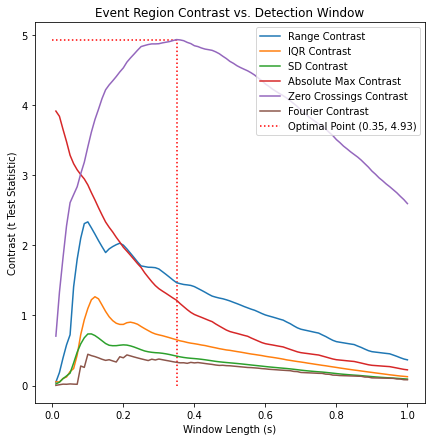

In [16]:
contrasts = pd.read_csv(output_filename_event_det_opt, header=None)
contrasts.columns = ["window_size", "file"] + list(tfn_candidates.keys())
contrasts_total = contrasts.groupby("window_size").mean()

plt.figure(figsize=(7, 7))
for stat in tfn_candidates.keys():
    plt.plot(contrasts_total.index/samprate,
             np.abs(contrasts_total[stat]),
             label = f"{stat} Contrast", alpha = 1)

plt.title("Event Region Contrast vs. Detection Window")
plt.xlabel("Window Length (s)")    
plt.ylabel("Contrast (t Test Statistic)")  
opt_det_window = contrasts_total.index[np.argmax(np.abs(contrasts_total["Zero Crossings"]))]/samprate
opt_det_window_val = np.max(np.abs(contrasts_total["Zero Crossings"]))
plt.vlines(opt_det_window, 0, opt_det_window_val,"r", ":", 
           label=f"Optimal Point ({round(opt_det_window, 2)}, {round(opt_det_window_val, 2)})")
plt.hlines(opt_det_window_val, 0, opt_det_window,"r", ":")
plt.legend(loc="upper right")
plt.savefig(OUT_PATH+"contrast.png")

#### Threshold Optimisation

In [12]:
calibration_window_sec = 5

st_list = []
f_score_list = []
for st_scale in np.linspace(0.01, 1, 100):
    fps, fns, tps, i = 0, 0, 0, 0
    for key in waves.keys():
        predictions, predictions_timestamps = streaming_classifier(
            waves[key],
            samprate,
            lambda x,y: "R" if np.random.rand()<0.5 else "L",
            input_buffer_size_sec = 0.05,
            classification_window_size_sec = opt_det_window,
            detection_window_size_sec = opt_det_window,
            detection_window_offset_sec = 0,
            calibration_window_size_sec = 5,
            calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
            event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
            event_threshold_factor = st_scale, 
            flip_threshold = True, 
            consecutive_event_triggers = 3, 
            consecutive_nonevent_reset = 10 
        )
        before_buffer = time_buffers_hump[key][0]
        after_buffer = time_buffers_hump[key][1]
        actual_times = [(time-before_buffer, time+after_buffer) for time in labels[key].time]
        actual_leftovers = deepcopy(actual_times)
        pred_leftovers = deepcopy(predictions_timestamps)
        tps += len(actual_times)
        for act_times in actual_times:
            if act_times[1] < calibration_window_sec:
                actual_leftovers.remove(act_times)
                continue
            for pred_times in predictions_timestamps:
                if (act_times[0] < pred_times[1] and act_times[1] > pred_times[0] and
                    pred_times in pred_leftovers and act_times in actual_leftovers):
                    actual_leftovers.remove(act_times)
                    pred_leftovers.remove(pred_times)
        tps -= len(actual_leftovers)
        fns += len(actual_leftovers)
        fps += len(pred_leftovers)
        i += 1
    fscore = tps/(tps+0.5*(fns+fps))
    if (st_scale*100)%10 == 0:
        print(st_scale, fscore)
    st_list.append(st_scale)
    f_score_list.append(fscore)


0.09999999999999999 0.7596153846153846
0.2 0.957345971563981
0.3 0.9859154929577465
0.4 0.9674418604651163
0.5 0.9493087557603687
0.6 0.9483568075117371
0.7000000000000001 0.9295774647887324
0.8 0.8909952606635071
0.9 0.7830188679245284
1.0 0.5625


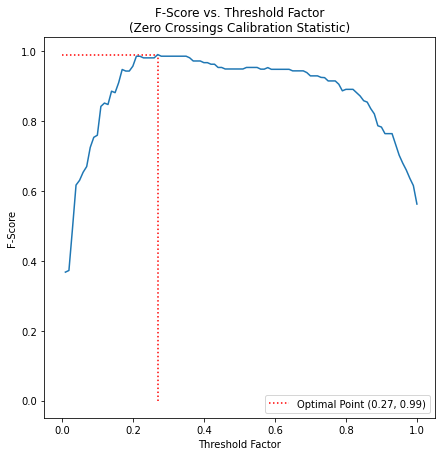

In [13]:
plt.figure(figsize=(7, 7))
plt.plot(st_list, f_score_list)
plt.title("F-Score vs. Threshold Factor\n(Zero Crossings Calibration Statistic)")
st_list = np.array(st_list)
opt_thresh = np.mean(st_list[f_score_list == np.max(f_score_list)])
opt_fscore = np.max(f_score_list)
plt.vlines(opt_thresh, 0, opt_fscore, "r", ":", 
           label=f"Optimal Point ({round(opt_thresh, 2)}, {round(opt_fscore, 2)})")
plt.hlines(opt_fscore, 0, opt_thresh, "r", ":")
plt.xlabel("Threshold Factor")
plt.ylabel("F-Score")
plt.legend(loc = "lower right")
plt.savefig(OUT_PATH+"threshold.png")

### Classification

#### Classifiers

In [14]:
# Prepare Classifier Candidates

# catch22 kNN classifier (using stepwise selected features)
step_csv = DEP_PATH+"catch22_step_selected_features.csv"
catch22_step_training_data = pd.read_csv(step_csv)
X_train = catch22_step_training_data.iloc[:,0:-1]
y_labels = catch22_step_training_data.iloc[:,-1]   
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_labels)

# "Zeros" classifier
# returns a list of sub-arrays, grouped by the same consecutive value
# (in this case they are groups of consecutive 1s or -1s) 

@njit # numba decorator that performs just-in-time (jit) compilation
def consecutive(data, stepsize=0):                              
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

# looks for the first sequence where the sign doesn't change for a period of time,
# checks whether the average height is higher or lower than a threshold then classifies
@njit 
def zeroes_classifier(arr, samprate, downsample_rate=10, ave_height = 10, consec_seconds = 0.2):
    arr_ds = arr[0::downsample_rate]
    arr_sign = np.sign(arr_ds)            
    i = 0
    split_arrays = consecutive(arr_sign)  
    for sub_arr in split_arrays:
        if len(sub_arr) > consec_seconds * samprate / downsample_rate:  # RHS converts seconds to number of samples
            # if there were 'consec_seconds' seconds of no zero-crossings,
            # check if the average height is bigger than 'ave_height'
            if np.mean(arr_ds[i:(i + len(sub_arr) - 1)]) > ave_height:          
                return 'R'
            elif np.mean(arr_ds[i:(i + len(sub_arr) - 1)]) < -1 * ave_height:
                return 'L'
        i += len(sub_arr)
    return '_'   

# calculates the 5 features selected from catch22, find the 5 nearest neighbours 
# calculated using Euclidean distance, then selects the majority classification
def catch22_knn_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_list = arr_ds.tolist()
    feature_one = catch22.DN_HistogramMode_5(arr_list)
    feature_two = catch22.SB_BinaryStats_mean_longstretch1(arr_list)
    feature_three = catch22.FC_LocalSimple_mean1_tauresrat(arr_list)
    feature_four = catch22.DN_OutlierInclude_p_001_mdrmd(arr_list)
    feature_five = catch22.SP_Summaries_welch_rect_area_5_1(arr_list)
    test_features = [[feature_one, feature_two, feature_three, feature_four, feature_five]]
    return neigh.predict(test_features)[0]                    

# wave is smoothed using Savitzky-Golay Filter, then decides whether the event is
# a left or right depending on whether the first turning point is a max or min
def one_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]

    if val_and_idx_sorted.shape == (3, 0):
        if val_and_idx_sorted[2] == -1:
            return 'L'
        elif val_and_idx_sorted[2] == 1:
            return 'R'
        else:
            return "_"
    else:
        if val_and_idx_sorted[2, 0] == -1:
            return 'L'
        elif val_and_idx_sorted[2, 0] == 1:
            return 'R'
        else:
            return "_"

# wave is smoothed using Savitzky-Golay Filter, then decides whether the event is
# a left or right depending on the order of the maximum and minimum turning points
def two_pronged_smoothing_classifier(arr, samprate, downsample_rate=10, 
                                       window_size_seconds=0.3, max_loops=10):
    arr_ds = arr[0::downsample_rate]
    fs = samprate/downsample_rate
    dt = 1/fs
    t = np.arange(0, (len(arr_ds)*dt), dt)

    # Smooth wave
    window_length = int(window_size_seconds*samprate/downsample_rate + 1)
    filtered_arr = signal.savgol_filter(arr_ds, window_length, 1)

    # Indices of positive maxima
    max_locs = np.array(signal.argrelextrema(filtered_arr, np.greater)[0])
    max_vals = filtered_arr[max_locs]
    max_locs = max_locs[max_vals > 0]
    
    # Indices of negative minima
    min_locs = np.array(signal.argrelextrema(filtered_arr, np.less)[0])
    min_vals = filtered_arr[min_locs]
    min_locs = min_locs[min_vals < 0]
    
    max_min_locs = np.append(max_locs, min_locs)    # Appended indices
    max_min_values = filtered_arr[max_min_locs]     # Values of above indices    
    abs_max_min_values = np.abs(max_min_values)     # Absolute value of those values

    # A vector with a length equal to the number of minimums: all '-1' to say minimum
    numMin = [-1]*len(min_locs)    
    numMax = [1]*len(max_locs)     # Same for max, but with '1'
    isMin = np.append(numMax, numMin)
    val_and_idx = np.vstack([abs_max_min_values, max_min_locs, isMin])
    # Sort the magnitudes of the extrema in descending order (-1 indicates descending)
    val_and_idx_sorted = val_and_idx[ :, (-1*val_and_idx[0]).argsort()]
    
    # We will continue looping until we have an appropriate classification. 
    # This relies on having the extrema INTERCHANGE between max and min (no two min right next to eachother)
    loops = 0
    classificationFound = False
    while not classificationFound and loops < max_loops:
        
        top_2 = val_and_idx_sorted[:, 0:2]             # Take the top two magnitudes
        top_2_sorted = top_2[ :, top_2[1].argsort()]   # Sort according to the indices of those values
        if top_2_sorted.shape != (3, 2):               # Break if we run out of turning points
            return "_"
        
        # If two min or two max occur one after the other, 
        # we know we have an inappropriate result so we delete one of those doubled min/max
        if top_2_sorted[2, 0]*top_2_sorted[2, 1] > 0:
            val_and_idx_sorted = np.delete(val_and_idx_sorted, 1, 1)
        else:
            classificationFound = True
        loops += 1
    if top_2_sorted[2, 0] == -1:
        return 'L'
    elif top_2_sorted[2, 0] == 1:
        return 'R'
    else:
        return "_"

# finds the index of the max and min values in the wave, then classifies
# based on whether the max or min value occurred first
def max_min_classifier(arr, samprate, downsample_rate=10):
    arr_ds = arr[0::downsample_rate]
    arr_max = np.amax(arr_ds)
    arr_min = np.amin(arr_ds)
    max_loc = np.where(arr_ds == arr_max)[0][0]
    min_loc = np.where(arr_ds == arr_min)[0][0]
    if max_loc > min_loc:
        return "R"
    elif min_loc > max_loc:
        return "L"
    else:
        return "_"

# finds the index of the max and min values in the wave, then checks whether both
# values are outside the range. If both are outside, then classification is based
# on whether max or min value occurred first. Else, if only one is outside, then
# classification is based on whether the max or min's magnitude is larger
def max_min_range_classifier(arr, samprate, downsample_rate=10, rng = 35):
    arr_ds = arr[0::downsample_rate]
    arr_max = np.amax(arr_ds)
    arr_min = np.amin(arr_ds)
    max_loc = np.where(arr_ds == arr_max)[0][0]
    min_loc = np.where(arr_ds == arr_min)[0][0]

    if arr_max > rng and arr_min < -1 * rng:
        if max_loc > min_loc:
            return "R"
        elif min_loc > max_loc:
            return "L"
        else:
            return "_"
    elif arr_max > rng:
        return "R"
    elif arr_min < -1 * rng:
        return "L"
    else:
        return "_"


In [15]:
# Prepare classifiers for optimisation and plotting
classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Two-pronged": two_pronged_smoothing_classifier,
               "Max-Min": max_min_classifier,
               "Max-Min-Range": max_min_range_classifier,
               "Zeros": zeroes_classifier,
               "KNN": catch22_knn_classifier,
               "Naive Random": lambda x,y: "R" if np.random.rand()<0.5 else "L",
               "Naive Undecided": lambda x,y: "_"}

classifier_parameters = {"One-pronged": {},
               "Two-pronged": {},
               "Max-Min": {},
               "Max-Min-Range": {"rng":35},
               "Zeros": {"consec_seconds": 0.2, "ave_height": 0.25},
               "KNN": {},
               "Naive Random": {},
               "Naive Undecided": {}}

classifier_colours = {"One-pronged": "tab:blue",
               "Two-pronged": "tab:cyan",
               "Max-Min": "tab:olive",
               "Max-Min-Range": "tab:brown",
               "Zeros": "tab:purple",
               "KNN": "tab:pink",
               "Naive Random": "tab:red",
               "Naive Undecided": "tab:orange"}


#### Accuracy Metric

In [16]:
def my_lev_dist(prediction, actual, L_cost = 1.25, R_cost = 1.25, under_score_cost = 0.5):
    substitute_costs = np.ones((128, 128), dtype=np.float64)  
    substitute_costs[ord('L'), ord('R')] = L_cost
    substitute_costs[ord('R'), ord('L')] = R_cost
    substitute_costs[ord('_'), ord('L')] = under_score_cost
    substitute_costs[ord('_'), ord('R')] = under_score_cost
    return lev(prediction, actual, substitute_costs = substitute_costs)


#### Classifier Optimisation

In [17]:
output_filename_cls_opt = OUT_PATH + "classifier_optimisation.csv"
open(output_filename_cls_opt, 'w').close()    # Clear the file

search_space = (2-opt_det_window)/2
granularity = 200

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    for i, w in enumerate(np.linspace(0, search_space, granularity)):
        w = max(1e-5, w)
        if i%(granularity//10) == 0:
            print(f"{i} of {granularity}")
        classification_window = opt_det_window+2*w
        buffer_size = 0.05
        for i, key in enumerate(waves):
            predictions, predictions_timestamps = streaming_classifier(
                waves[key],
                samprate,
                classifier,
                classifier_params=classifier_parameters[classifier_label],
                input_buffer_size_sec = buffer_size,
                classification_window_size_sec = classification_window,
                detection_window_size_sec = opt_det_window,
                detection_window_offset_sec = w,
                calibration_window_size_sec = 5,
                calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
                event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
                event_threshold_factor = opt_thresh, 
                flip_threshold = True, # Threshold is a lower bound, so true
                consecutive_event_triggers = 3, 
                consecutive_nonevent_reset = 10 
            )
            actuals = "".join(labels[key].label)
            lev_dist = my_lev_dist(predictions, actuals)
            acc = max((len(actuals) - lev_dist), 0)/len(actuals)
            with open(output_filename_cls_opt, "a") as file:
                file.write(",".join([classifier_label, str(classification_window), 
                                     key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')


One-pronged
0 of 200


<ipython-input-14-f350c6c0198c>:82: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if val_and_idx_sorted[2] == -1:
<ipython-input-14-f350c6c0198c>:84: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  elif val_and_idx_sorted[2] == 1:


20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Two-pronged
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Max-Min
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Max-Min-Range
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Zeros
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
KNN
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Naive Random
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200
Naive Undecided
0 of 200
20 of 200
40 of 200
60 of 200
80 of 200
100 of 200
120 of 200
140 of 200
160 of 200
180 of 200


In [18]:
results = pd.read_csv(output_filename_cls_opt, header=None)
results.columns = ["classifier", "window_size", "file", "predicted", "actual", "lev_dist", "accuracy"]
results_agg = results.groupby(["window_size", "classifier"]).mean()
results_agg.reset_index(inplace=True)
results_agg

,window_size,classifier,lev_dist,accuracy
0,0.35002,KNN,8.875000,0.506063
1,0.35002,Max-Min,5.916667,0.655378
2,0.35002,Max-Min-Range,0.541667,0.967249
3,0.35002,Naive Random,6.916667,0.623820
4,0.35002,Naive Undecided,9.083333,0.476307
...,...,...,...,...
1595,2.00000,Naive Random,7.375000,0.567870
1596,2.00000,Naive Undecided,9.083333,0.478700
1597,2.00000,One-pronged,2.916667,0.817296
1598,2.00000,Two-pronged,8.750000,0.491019


1.7595477386934673 0.4787000439174353


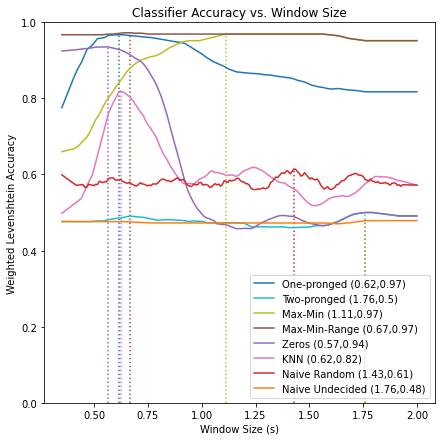

In [19]:
optimal_cl_windows = {}

plt.figure(figsize=(7, 7))
for classifier in results.classifier.unique():
    filt = results_agg.classifier == classifier
    max_arg = np.argmax(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    max_val = np.max(signal.savgol_filter(results_agg[filt].accuracy, 15, 1))
    optimal_cl_window = np.array(results_agg[filt].window_size)[max_arg]
    optimal_cl_windows[classifier] = optimal_cl_window
    
    plt.plot(results_agg[filt].window_size, signal.savgol_filter(results_agg[filt].accuracy, 15, 1),
             label=classifier + f" ({round(optimal_cl_window, 2)},{round(max_val, 2)})", color=classifier_colours[classifier])
    plt.vlines(optimal_cl_window, 0, max_val, color=classifier_colours[classifier], linestyle=":")
    
plt.ylabel("Weighted Levenshtein Accuracy")
plt.xlabel("Window Size (s)")
plt.title("Classifier Accuracy vs. Window Size")
plt.ylim(0, 1)

plt.legend(loc="lower right")
print(optimal_cl_window, max_val)
plt.savefig(OUT_PATH+"classifier.png")

## Evaluation

In [20]:
output_filename_tst_res = OUT_PATH + "test_results.csv"
open(output_filename_tst_res, 'w').close()    # Clear the file

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
    buffer_size = 0.05
    for i, key in enumerate(test_waves):
        predictions, predictions_timestamps = streaming_classifier(
            test_waves[key],
            samprate,
            classifier,
            classifier_params=classifier_parameters[classifier_label],
            input_buffer_size_sec = buffer_size,
            classification_window_size_sec = optimal_cl_windows[classifier_label],
            detection_window_size_sec = opt_det_window,
            detection_window_offset_sec = offset,
            calibration_window_size_sec = 5,
            calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
            event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
            event_threshold_factor = opt_thresh, 
            flip_threshold = True,
            consecutive_event_triggers = 3, 
            consecutive_nonevent_reset = 10 
        )
        actuals = "".join(test_labels[key].label)
        lev_dist = my_lev_dist(predictions, actuals)
        acc = max((len(actuals) - lev_dist), 0)/len(actuals)
        with open(output_filename_tst_res, "a") as file:
            file.write(",".join([classifier_label, key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')


One-pronged
Two-pronged
Max-Min
Max-Min-Range
Zeros
KNN
Naive Random
Naive Undecided


In [21]:
test_results = pd.read_csv(output_filename_tst_res, header=None)
test_results.columns = ["Classifier", "File", "Predicted", "Actual", "Weighted Levenshtein Distance", "Accuracy"]

test_results = test_results.pivot(index = "File", columns='Classifier', values='Accuracy')
test_results.loc['Total']= test_results.mean()
test_results

Classifier,KNN,Max-Min,Max-Min-Range,Naive Random,Naive Undecided,One-pronged,Two-pronged,Zeros
File,,,,,,,,
data5,0.787037,0.925926,0.962963,0.592593,0.462963,0.925926,0.685185,0.888889
data7,0.750000,0.870968,0.838710,0.685484,0.435484,0.870968,0.669355,0.838710
Total,0.768519,0.898447,0.900836,0.639038,0.449223,0.898447,0.677270,0.863799


## Space Invaders!

In [22]:
def encode_msg_size(size: int) -> bytes:
    return struct.pack("<I", size)

def decode_msg_size(size_bytes: bytes) -> int:
    return struct.unpack("<I", size_bytes)[0]

def create_msg(content: bytes) -> bytes:
    size = len(content)
    return encode_msg_size(size) + content


## Appendix

In [23]:
# Final classifier used for Space Invaders
baudrate = 230400
cport = "/dev/cu.usbserial-DJ00E33Q"
ser = serial.Serial(port=cport, baudrate=baudrate)    
inputBufferSize = 1000   # 20000 = 1 second
buffer_size_sec = inputBufferSize/20000.0
ser.timeout = buffer_size_sec  # set read timeout 20000

classifier_label = "One-pronged"

print(classifier_label)
offset = (optimal_cl_windows[classifier_label] - opt_det_window)/2
buffer_size = 0.05
streaming_classifier(
    ser,
    samprate,
    classifiers[classifier_label],
    classifier_params=classifier_parameters[classifier_label],
    input_buffer_size_sec = buffer_size_sec,
    classification_window_size_sec = optimal_cl_windows[classifier_label],
    detection_window_size_sec = opt_det_window,
    detection_window_offset_sec = offset,
    calibration_window_size_sec = 5,
    calibration_statistic_function = lambda x: ts_zero_crossings(x)/len(x),
    event_test_statistic_function = lambda x: ts_zero_crossings(x)/len(x), 
    event_threshold_factor = opt_thresh, 
    flip_threshold = True, 
    consecutive_event_triggers = 3, 
    consecutive_nonevent_reset = 10,
    live = True,
    FIFO_filename = "space_invaders_ipc",
    create_FIFO_msg = None,
    )


## References 

e.g {cite}`holdgraf_rapid_2016`

```{bibliography}
```

http://blog.juliusschulz.de/blog/ultimate-ipython-notebook